In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install gspread gspread_dataframe --quiet
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

In [8]:
from gspread_dataframe import get_as_dataframe

SHEET_URL = "https://docs.google.com/spreadsheets/d/1t-Ncm7mok0Tf_0E6asgNZBDxgq1fPLnAdzBPpQwG7GA/edit#gid=0"

sh = gc.open_by_url(SHEET_URL)
ws = sh.sheet1   # first tab

df = get_as_dataframe(ws, evaluate_formulas=True)
df = df.dropna(how="all").reset_index(drop=True)

df.head()

,ID,Consent,age,bmi,smoking_history,heart_disease,hypertension,Tongue Image,gender,diabetes
0,P-001,I Agree,51.0,26.8,Former,no,yes,https://drive.google.com/open?id=1GPGxWqIHCQ7R...,Male,1.0
1,P-002,I Agree,52.0,23.1,Never,no,no,https://drive.google.com/open?id=1J7sVIxC1GJNi...,Male,1.0
2,P-003,I Agree,66.0,24.0,Former,yes,yes,https://drive.google.com/open?id=1c_G2QWrBtkqn...,Male,1.0
3,P-004,I Agree,53.0,25.7,Never,no,yes,https://drive.google.com/open?id=1A7oCrklp6blC...,Female,1.0
4,P-005,I Agree,82.0,33.6,Never,no,yes,https://drive.google.com/open?id=17lSULebk4Tiu...,Female,1.0


In [10]:
df.columns


Index(['ID', 'Consent', 'age', 'bmi', 'smoking_history', 'heart_disease',
       'hypertension', 'Tongue Image', 'gender', 'diabetes'],
      dtype='object')

In [11]:
import re

URL_COL = "Tongue Image"

def extract_file_id(url):
    if isinstance(url, str):
        # Pattern 1
        m = re.search(r"/file/d/([A-Za-z0-9_-]+)/", url)
        if m:
            return m.group(1)
        # Pattern 2
        m = re.search(r"id=([A-Za-z0-9_-]+)", url)
        if m:
            return m.group(1)
    return None

df["file_id"] = df[URL_COL].apply(extract_file_id)
df[["ID", URL_COL, "file_id"]].head()


,ID,Tongue Image,file_id
0,P-001,https://drive.google.com/open?id=1GPGxWqIHCQ7R...,1GPGxWqIHCQ7RlNsUEldTDat9xMYzjvWL
1,P-002,https://drive.google.com/open?id=1J7sVIxC1GJNi...,1J7sVIxC1GJNiZxJR0_8G09PFc9DYB2UV
2,P-003,https://drive.google.com/open?id=1c_G2QWrBtkqn...,1c_G2QWrBtkqnIBGSy_cbLuI57ELiq0Az
3,P-004,https://drive.google.com/open?id=1A7oCrklp6blC...,1A7oCrklp6blCcyxVnyAtAwuSHtlU4nyH
4,P-005,https://drive.google.com/open?id=17lSULebk4Tiu...,17lSULebk4Tiu4N4lUqe5b4jvhOcI-CUu


In [13]:
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload

service = build('drive', 'v3', credentials=creds)

# 2. Create output folder
import os
import io

RAW_IMG_DIR = "/content/drive/MyDrive/T2DM_paired/raw_tongue_images"
os.makedirs(RAW_IMG_DIR, exist_ok=True)

# 3. Helper function: download by file_id
def download_from_drive(file_id, dest_path):
    """
    Download a file from Google Drive using its file_id
    and save it to dest_path.
    """
    request = service.files().get_media(fileId=file_id)
    fh = io.FileIO(dest_path, 'wb')
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while not done:
        status, done = downloader.next_chunk()
        # If you want to see progress, uncomment:
        if status:
           print(f"Download {int(status.progress() * 100)}%.")

# 4. Loop over rows in df and download each image
# Assumes df has columns: "ID" and "file_id"
from tqdm import tqdm

for _, row in tqdm(df.iterrows(), total=len(df)):
    pid = row["ID"]
    fid = row["file_id"]

    # skip rows without a valid file_id
    if not isinstance(fid, str) or fid.strip() == "":
        print(f"Skipping {pid}: no file_id")
        continue

    out_path = os.path.join(RAW_IMG_DIR, f"{pid}.jpg")  # name file as <ID>.jpg

    # if already downloaded, skip
    if os.path.exists(out_path):
        continue

    try:
        print(f"Downloading {pid} -> {out_path}")
        download_from_drive(fid, out_path)
    except Exception as e:
        print(f"Failed for {pid} (file_id={fid}): {e}")


  0%|          | 0/90 [00:00<?, ?it/s]

  1%|          | 1/90 [00:01<02:25,  1.64s/it]

Download 100%.


  2%|▏         | 2/90 [00:02<01:30,  1.03s/it]

Download 100%.


  3%|▎         | 3/90 [00:02<01:16,  1.13it/s]

Download 100%.


  4%|▍         | 4/90 [00:04<01:36,  1.12s/it]

Download 100%.


  6%|▌         | 5/90 [00:05<01:31,  1.08s/it]

Download 100%.


  7%|▋         | 6/90 [00:06<01:20,  1.05it/s]

Download 100%.


  8%|▊         | 7/90 [00:06<01:08,  1.21it/s]

Download 100%.


  9%|▉         | 8/90 [00:07<01:00,  1.35it/s]

Download 100%.


 10%|█         | 9/90 [00:07<00:53,  1.52it/s]

Download 100%.


 11%|█         | 10/90 [00:08<00:48,  1.65it/s]

Download 100%.


 12%|█▏        | 11/90 [00:08<00:48,  1.61it/s]

Download 100%.


 13%|█▎        | 12/90 [00:09<00:55,  1.41it/s]

Download 100%.


 14%|█▍        | 13/90 [00:10<00:45,  1.71it/s]

Download 100%.


 16%|█▌        | 14/90 [00:10<00:48,  1.56it/s]

Download 100%.


 17%|█▋        | 15/90 [00:11<00:51,  1.46it/s]

Download 100%.


 18%|█▊        | 16/90 [00:12<00:46,  1.60it/s]

Download 100%.


 19%|█▉        | 17/90 [00:12<00:44,  1.64it/s]

Download 100%.


 20%|██        | 18/90 [00:13<00:43,  1.66it/s]

Download 100%.


 21%|██        | 19/90 [00:13<00:43,  1.63it/s]

Download 100%.


 22%|██▏       | 20/90 [00:15<00:55,  1.27it/s]

Download 100%.


 23%|██▎       | 21/90 [00:16<00:58,  1.17it/s]

Download 100%.


 24%|██▍       | 22/90 [00:16<00:49,  1.38it/s]

Download 100%.


 26%|██▌       | 23/90 [00:17<00:53,  1.24it/s]

Download 100%.


 27%|██▋       | 24/90 [00:18<00:59,  1.11it/s]

Download 100%.


 28%|██▊       | 25/90 [00:19<00:57,  1.13it/s]

Download 100%.


 29%|██▉       | 26/90 [00:21<01:12,  1.14s/it]

Download 100%.


 30%|███       | 27/90 [00:22<01:08,  1.08s/it]

Download 100%.


 31%|███       | 28/90 [00:22<01:01,  1.01it/s]

Download 100%.


 32%|███▏      | 29/90 [00:23<00:55,  1.10it/s]

Download 100%.


 33%|███▎      | 30/90 [00:24<00:47,  1.26it/s]

Download 100%.


 34%|███▍      | 31/90 [00:24<00:44,  1.33it/s]

Download 100%.


 36%|███▌      | 32/90 [00:26<00:57,  1.01it/s]

Download 100%.


 37%|███▋      | 33/90 [00:26<00:48,  1.18it/s]

Download 100%.


 38%|███▊      | 34/90 [00:28<00:51,  1.08it/s]

Download 100%.


 39%|███▉      | 35/90 [00:29<00:55,  1.01s/it]

Download 100%.


 40%|████      | 36/90 [00:30<00:56,  1.04s/it]

Download 100%.


 41%|████      | 37/90 [00:31<00:58,  1.10s/it]

Download 100%.


 42%|████▏     | 38/90 [00:32<01:00,  1.16s/it]

Download 100%.


 43%|████▎     | 39/90 [00:34<01:05,  1.29s/it]

Download 100%.


 44%|████▍     | 40/90 [00:35<00:56,  1.13s/it]

Download 100%.


 46%|████▌     | 41/90 [00:36<00:52,  1.08s/it]

Download 100%.


 47%|████▋     | 42/90 [00:37<00:56,  1.17s/it]

Download 100%.


 48%|████▊     | 43/90 [00:38<00:57,  1.22s/it]

Download 100%.


 49%|████▉     | 44/90 [00:40<00:58,  1.26s/it]

Download 100%.


 50%|█████     | 45/90 [00:41<00:55,  1.24s/it]

Download 100%.


 51%|█████     | 46/90 [00:42<00:47,  1.08s/it]

Download 100%.


 52%|█████▏    | 47/90 [00:42<00:40,  1.05it/s]

Download 100%.


 53%|█████▎    | 48/90 [00:44<00:42,  1.02s/it]

Download 100%.


 54%|█████▍    | 49/90 [00:45<00:46,  1.13s/it]

Download 100%.


 56%|█████▌    | 50/90 [00:46<00:50,  1.26s/it]

Download 100%.


 57%|█████▋    | 51/90 [00:49<01:02,  1.61s/it]

Download 100%.


 58%|█████▊    | 52/90 [00:49<00:49,  1.29s/it]

Download 100%.


 59%|█████▉    | 53/90 [00:50<00:41,  1.12s/it]

Download 100%.


 60%|██████    | 54/90 [00:51<00:42,  1.17s/it]

Download 100%.


 61%|██████    | 55/90 [00:52<00:38,  1.10s/it]

Download 100%.


 62%|██████▏   | 56/90 [00:53<00:30,  1.10it/s]

Download 100%.


 63%|██████▎   | 57/90 [00:54<00:28,  1.14it/s]

Download 100%.


 64%|██████▍   | 58/90 [00:56<00:42,  1.33s/it]

Download 100%.


 66%|██████▌   | 59/90 [00:57<00:40,  1.32s/it]

Download 100%.


 67%|██████▋   | 60/90 [00:58<00:34,  1.16s/it]

Download 100%.


 68%|██████▊   | 61/90 [00:59<00:28,  1.01it/s]

Download 100%.


 69%|██████▉   | 62/90 [00:59<00:25,  1.11it/s]

Download 100%.


 70%|███████   | 63/90 [01:00<00:21,  1.25it/s]

Download 100%.


 71%|███████   | 64/90 [01:01<00:22,  1.13it/s]

Download 100%.


 72%|███████▏  | 65/90 [01:02<00:21,  1.15it/s]

Download 100%.


 73%|███████▎  | 66/90 [01:03<00:20,  1.18it/s]

Download 100%.


 74%|███████▍  | 67/90 [01:03<00:17,  1.35it/s]

Download 100%.


 76%|███████▌  | 68/90 [01:04<00:16,  1.33it/s]

Download 100%.


 77%|███████▋  | 69/90 [01:05<00:16,  1.27it/s]

Download 100%.


 78%|███████▊  | 70/90 [01:06<00:15,  1.28it/s]

Download 100%.


 79%|███████▉  | 71/90 [01:07<00:17,  1.06it/s]

Download 100%.


 80%|████████  | 72/90 [01:08<00:15,  1.15it/s]

Download 100%.


 81%|████████  | 73/90 [01:08<00:13,  1.22it/s]

Download 100%.


 82%|████████▏ | 74/90 [01:09<00:13,  1.15it/s]

Download 100%.


 83%|████████▎ | 75/90 [01:10<00:10,  1.40it/s]

Download 100%.


 84%|████████▍ | 76/90 [01:11<00:13,  1.08it/s]

Download 100%.


 86%|████████▌ | 77/90 [01:12<00:10,  1.23it/s]

Download 100%.


 87%|████████▋ | 78/90 [01:13<00:12,  1.01s/it]

Download 100%.


 88%|████████▊ | 79/90 [01:14<00:09,  1.10it/s]

Download 100%.


 89%|████████▉ | 80/90 [01:14<00:07,  1.27it/s]

Download 100%.


 90%|█████████ | 81/90 [01:15<00:06,  1.43it/s]

Download 100%.


 91%|█████████ | 82/90 [01:16<00:05,  1.39it/s]

Download 100%.


 92%|█████████▏| 83/90 [01:17<00:05,  1.25it/s]

Download 100%.


 93%|█████████▎| 84/90 [01:18<00:05,  1.08it/s]

Download 100%.


 94%|█████████▍| 85/90 [01:18<00:04,  1.17it/s]

Download 100%.


 96%|█████████▌| 86/90 [01:19<00:03,  1.32it/s]

Download 100%.


 97%|█████████▋| 87/90 [01:20<00:02,  1.24it/s]

Download 100%.


 98%|█████████▊| 88/90 [01:21<00:01,  1.09it/s]

Download 100%.


 99%|█████████▉| 89/90 [01:22<00:00,  1.11it/s]

Download 100%.


100%|██████████| 90/90 [01:23<00:00,  1.07it/s]

Download 100%.


In [17]:
!pip install segmentation-models-pytorch
import os, cv2, torch, numpy as np
from tqdm import tqdm
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

# -------- Paths --------
DRIVE_ROOT   = "/content/drive/MyDrive"
PROJECT_ROOT = os.path.join(DRIVE_ROOT, "TongueImagediabetes/data")

SEG_RUN_DIR   = os.path.join(PROJECT_ROOT, "segmentation_runs")
SEG_CKPT_PATH = os.path.join(SEG_RUN_DIR, "tongue_unetpp_effb3_best.pt")

RAW_IMG_DIR  = "/content/drive/MyDrive/T2DM_paired/raw_tongue_images"
PREP_IMG_DIR = "/content/drive/MyDrive/T2DM_paired/preprocessed_tongue_images"
os.makedirs(PREP_IMG_DIR, exist_ok=True)

# -------- Device --------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------- Segmentation model (same as before) --------
SEG_SIZE = 512

infer_model = smp.UnetPlusPlus(
    encoder_name="timm-efficientnet-b0",
    encoder_weights=None,
    in_channels=3,
    classes=1
).to(device)

infer_model.load_state_dict(torch.load(SEG_CKPT_PATH, map_location=device))
infer_model.eval()
print("Loaded checkpoint from:", SEG_CKPT_PATH)

# Albumentations transform: same as training but deterministic
infer_transform = A.Compose(
    [
        A.LongestMaxSize(max_size=SEG_SIZE),
        A.PadIfNeeded(
            SEG_SIZE, SEG_SIZE,
            border_mode=cv2.BORDER_CONSTANT,
            value=0, mask_value=0, position="center"
        ),
        A.Normalize(),
        ToTensorV2()
    ]
)

# --- letterbox helpers (for mapping mask back to original size) ---
def letterbox_params(orig_h, orig_w, size):
    scale = min(size / float(orig_h), size / float(orig_w))
    new_h = int(round(orig_h * scale))
    new_w = int(round(orig_w * scale))
    pad_h = size - new_h
    pad_w = size - new_w
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    return scale, (top, bottom, left, right), (new_h, new_w)

def mask_to_original(mask_512, orig_h, orig_w, size=512):
    """
    Remove padding from a 512x512 letterboxed mask and resize back to
    the original image shape (orig_h, orig_w). Returns a 0/1 float32 mask.
    """
    scale, (top, bottom, left, right), (new_h, new_w) = letterbox_params(orig_h, orig_w, size)

    h, w = mask_512.shape
    y0 = top
    y1 = h - bottom if bottom > 0 else h
    x0 = left
    x1 = w - right if right > 0 else w
    mask_cropped = mask_512[y0:y1, x0:x1]

    mask_resized = cv2.resize(mask_cropped, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)
    mask_bin = (mask_resized > 0.5).astype("float32")
    return mask_bin

# --- gray-world white balance ---
def gray_world_white_balance(bgr: np.ndarray) -> np.ndarray:
    """
    Gray-world white balance: scale each channel so that its mean becomes
    the global gray level.
    """
    img = bgr.astype(np.float32)
    b, g, r = cv2.split(img)

    mean_b = b.mean()
    mean_g = g.mean()
    mean_r = r.mean()
    mean_gray = (mean_b + mean_g + mean_r) / 3.0 + 1e-6

    b *= mean_gray / (mean_b + 1e-6)
    g *= mean_gray / (mean_g + 1e-6)
    r *= mean_gray / (mean_r + 1e-6)

    wb = cv2.merge([b, g, r])
    wb = np.clip(wb, 0, 255).astype(np.uint8)
    return wb

def preprocess_for_t2dm(orig_bgr: np.ndarray,
                        mask01: np.ndarray,
                        out_size: int = 224):
    # --- this is copied from previous notebook, slightly shortened ---
    ys, xs = np.where(mask01 > 0)
    if len(ys) == 0 or len(xs) == 0:
        print("Warning: empty mask; returning blank.")
        tongue_img = np.zeros((out_size, out_size, 3), dtype=np.uint8)
        zero = np.zeros((out_size, out_size), dtype=np.uint8)
        return tongue_img, zero, zero, zero

    pad = 10
    h, w = orig_bgr.shape[:2]
    y0 = max(int(ys.min()) - pad, 0)
    y1 = min(int(ys.max()) + pad + 1, h)
    x0 = max(int(xs.min()) - pad, 0)
    x1 = min(int(xs.max()) + pad + 1, w)

    crop_bgr  = orig_bgr[y0:y1, x0:x1].copy()
    crop_mask = mask01[y0:y1, x0:x1].astype(np.uint8)

    # Small morphology to clean mask
    kernel = np.ones((3, 3), np.uint8)
    crop_mask = cv2.morphologyEx(crop_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    # For black bg outside tongue
    crop_bgr[crop_mask == 0] = 0

    wb_bgr = gray_world_white_balance(crop_bgr)

    lab = cv2.cvtColor(wb_bgr, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    L_eq = clahe.apply(L)

    lab_eq = cv2.merge([L_eq, a, b])
    bgr_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

     # ---------- 4. Resize to canonical size ----------
    tongue_img = cv2.resize(bgr_eq, (out_size, out_size),
                            interpolation=cv2.INTER_AREA)
    crop_mask_resized = cv2.resize(crop_mask, (out_size, out_size),
                                   interpolation=cv2.INTER_NEAREST)
    crop_mask_resized = (crop_mask_resized > 0).astype(np.uint8)

    # ---------- 5. Coating mask (bright + low saturation) ----------
    hsv = cv2.cvtColor(tongue_img, cv2.COLOR_BGR2HSV)
    Hc, Sc, Vc = cv2.split(hsv)

    coating = ((Sc < 80) & (Vc > 120) & (crop_mask_resized == 1)).astype(np.uint8)

    coating = cv2.morphologyEx(coating, cv2.MORPH_OPEN, kernel, iterations=1)
    coating = cv2.morphologyEx(coating, cv2.MORPH_CLOSE, kernel, iterations=1)
    coating_u8 = (coating * 255).astype(np.uint8)

    # ---------- 6. Distance transform (shape / thickness) ----------
    dist = cv2.distanceTransform(crop_mask_resized, cv2.DIST_L2, 3)
    dist_norm = cv2.normalize(dist, None, 0, 255, cv2.NORM_MINMAX)
    dist_u8 = dist_norm.astype(np.uint8)

    # ---------- 7. Gabor texture on enhanced L* ----------
    L_eq_resized = cv2.resize(L_eq, (out_size, out_size),
                              interpolation=cv2.INTER_AREA)

    ksize = 21
    gabor_kernel = cv2.getGaborKernel(
        ksize=(ksize, ksize),
        sigma=5.0,
        theta=0.0,       # horizontal structures
        lambd=10.0,
        gamma=0.5,
        psi=0,
        ktype=cv2.CV_32F
    )
    tex = cv2.filter2D(L_eq_resized, cv2.CV_32F, gabor_kernel)
    tex = cv2.normalize(tex, None, 0, 255, cv2.NORM_MINMAX)
    tex_u8 = tex.astype(np.uint8)

    tex_u8[crop_mask_resized == 0] = 0

    return tongue_img, coating_u8, dist_u8, tex_u8

# -------- Run segmentation + preprocessing for each downloaded image --------
TARGET_SIZE = 224

for fname in tqdm(os.listdir(RAW_IMG_DIR)):
    if not fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
        continue

    pid = os.path.splitext(fname)[0]
    in_path  = os.path.join(RAW_IMG_DIR, fname)
    out_path = os.path.join(PREP_IMG_DIR, f"{pid}.png")

    if os.path.exists(out_path):
        continue

    img_bgr = cv2.imread(in_path, cv2.IMREAD_COLOR)
    if img_bgr is None:
        print("WARNING: could not read", in_path)
        continue

    orig_h, orig_w = img_bgr.shape[:2]
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 1) segmentation at SEG_SIZE x SEG_SIZE
    augmented = infer_transform(image=img_rgb)
    img_t = augmented["image"].unsqueeze(0).to(device)

    with torch.no_grad():
        logits = infer_model(img_t)
        probs  = torch.sigmoid(logits)[0, 0].cpu().numpy()
    mask_512 = (probs > 0.5).astype("float32")

    # 2) mask back to original resolution
    mask_orig = mask_to_original(mask_512, orig_h, orig_w, size=SEG_SIZE)

    # 3) aspect-ratio / orientation check (optional)
    """ys, xs = np.where(mask_orig > 0)
    if len(ys) == 0 or len(xs) == 0:
        print("⚠ Empty mask — skipping:", in_path)
        continue

    height = ys.max() - ys.min()
    width  = xs.max() - xs.min()
    ratio = height / max(width, 1)
    if ratio < 0.8:
        print(f"❌ Rejected (too horizontal, ratio={ratio:.2f}): {in_path}")
        continue

    mask01 = (mask_orig > 0).astype(np.uint8)"""

    # 4) T2DM-focused preprocessing
    tongue_img_bgr, _, _, _ = preprocess_for_t2dm(img_bgr, mask_orig, out_size=TARGET_SIZE)

    # 5) save main processed tongue image as RGB PNG
    tongue_rgb = cv2.cvtColor(tongue_img_bgr, cv2.COLOR_BGR2RGB)
    Image.fromarray(tongue_rgb).save(out_path)

print("Done preprocessing. Saved images to:", PREP_IMG_DIR)


Using device: cpu


/tmp/ipython-input-492471718.py:42: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(


Loaded checkpoint from: /content/drive/MyDrive/TongueImagediabetes/data/segmentation_runs/tongue_unetpp_effb3_best.pt


100%|██████████| 90/90 [02:38<00:00,  1.77s/it]

Done preprocessing. Saved images to: /content/drive/MyDrive/T2DM_paired/preprocessed_tongue_images


In [19]:
import timm, torch
from torchvision import transforms
from PIL import Image
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PREP_IMG_DIR = "/content/drive/MyDrive/T2DM_paired/preprocessed_tongue_images"

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ),
])

# --- recreate classifier model and load weights ---
clf = timm.create_model("tf_efficientnet_b0", pretrained=False, num_classes=2)
clf.load_state_dict(torch.load(
    "/content/drive/MyDrive/TongueImagediabetes/data/best_classifier_finetuned.pth",
    map_location=device
))
clf = clf.to(device)
clf.eval()
print("Loaded classifier checkpoint.")

@torch.no_grad()
def image_prob_for_id(pid: str) -> float:
    img_path = os.path.join(PREP_IMG_DIR, f"{pid}.png")
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"No preprocessed image for ID {pid} at {img_path}")
    img = Image.open(img_path).convert("RGB")
    x = val_tfms(img).unsqueeze(0).to(device)
    logits = clf(x)
    probs = torch.softmax(logits, dim=1)[0, 0].item()  # P(diabetes)
    return probs

# --- add p_img to DataFrame df (from the Google Sheet) ---
df["p_img"] = np.nan

from tqdm import tqdm

for i in tqdm(range(len(df))):
    pid = df.loc[i, "ID"]
    try:
        df.loc[i, "p_img"] = image_prob_for_id(pid)
    except Exception as e:
        print("Failed for ID", pid, ":", e)

df[["ID", "p_img"]].head()


Using device: cpu
Loaded classifier checkpoint.


100%|██████████| 90/90 [00:06<00:00, 14.46it/s]


,ID,p_img
0,P-001,0.000204
1,P-002,0.028791
2,P-003,0.000772
3,P-004,0.999974
4,P-005,0.001294


In [23]:
import pandas as pd


all_results = []

print("\n--- p_img for all preprocessed images ---\n")
for pid in tqdm(df["ID"].values):
    try:
        p = image_prob_for_id(pid)
        all_results.append((pid, p))
        print(f"{pid}  -->  p_img = {p:.4f}")
    except Exception as e:
        print(f"{pid}  -->  ERROR: {e}")

# 5. Convert to DataFrame for inspection or saving

pimg_df = pd.DataFrame(all_results, columns=["ID", "p_img"])
pimg_df.head()


--- p_img for all preprocessed images ---



  2%|▏         | 2/90 [00:00<00:05, 15.37it/s]

P-001  -->  p_img = 0.0002
P-002  -->  p_img = 0.0288
P-003  -->  p_img = 0.0008


  7%|▋         | 6/90 [00:00<00:05, 14.78it/s]

P-004  -->  p_img = 1.0000
P-005  -->  p_img = 0.0013
P-006  -->  p_img = 0.0088
P-007  -->  p_img = 0.0046


 11%|█         | 10/90 [00:00<00:05, 15.48it/s]

P-008  -->  p_img = 0.0003
P-009  -->  p_img = 0.0004
P-010  -->  p_img = 0.3525
P-011  -->  p_img = 0.7833


 16%|█▌        | 14/90 [00:00<00:04, 15.56it/s]

P-012  -->  p_img = 0.0012
P-013  -->  p_img = 0.0138
P-014  -->  p_img = 0.8152
P-015  -->  p_img = 0.2148


 20%|██        | 18/90 [00:01<00:04, 15.62it/s]

P-016  -->  p_img = 0.0000
P-017  -->  p_img = 0.0000
P-018  -->  p_img = 0.9837
P-019  -->  p_img = 0.0103


 24%|██▍       | 22/90 [00:01<00:04, 15.36it/s]

P-020  -->  p_img = 0.2344
P-021  -->  p_img = 0.1599
P-022  -->  p_img = 0.1583
P-023  -->  p_img = 0.9682


 29%|██▉       | 26/90 [00:01<00:04, 15.49it/s]

P-024  -->  p_img = 0.0000
P-025  -->  p_img = 0.0008
P-026  -->  p_img = 0.0001
P-027  -->  p_img = 0.1007


 33%|███▎      | 30/90 [00:01<00:03, 15.63it/s]

P-028  -->  p_img = 0.0029
P-029  -->  p_img = 0.0000
P-030  -->  p_img = 1.0000
P-031  -->  p_img = 0.0005


 38%|███▊      | 34/90 [00:02<00:03, 15.43it/s]

P-032  -->  p_img = 0.0001
P-033  -->  p_img = 0.2291
P-034  -->  p_img = 0.0014
P-035  -->  p_img = 0.0763


 42%|████▏     | 38/90 [00:02<00:03, 15.07it/s]

P-036  -->  p_img = 0.0009
P-037  -->  p_img = 0.3419
P-038  -->  p_img = 0.0000
P-039  -->  p_img = 0.0000


 47%|████▋     | 42/90 [00:02<00:03, 15.07it/s]

P-040  -->  p_img = 0.0027
P-041  -->  p_img = 0.0001
P-042  -->  p_img = 0.2741
P-043  -->  p_img = 0.0505


 51%|█████     | 46/90 [00:03<00:02, 15.37it/s]

P-044  -->  p_img = 0.8352
P-045  -->  p_img = 0.9842
P-046  -->  p_img = 0.5372
P-047  -->  p_img = 0.0034


 56%|█████▌    | 50/90 [00:03<00:02, 15.54it/s]

P-048  -->  p_img = 0.0017
P-049  -->  p_img = 0.4411
P-050  -->  p_img = 0.0000
P-051  -->  p_img = 0.0083


 60%|██████    | 54/90 [00:03<00:02, 15.44it/s]

P-052  -->  p_img = 0.0021
P-053  -->  p_img = 0.0242
P-054  -->  p_img = 0.0005
P-055  -->  p_img = 0.0001


 64%|██████▍   | 58/90 [00:03<00:02, 15.65it/s]

P-056  -->  p_img = 0.0001
P-057  -->  p_img = 0.0413
P-058  -->  p_img = 0.8137
P-059  -->  p_img = 0.1178


 69%|██████▉   | 62/90 [00:04<00:01, 15.89it/s]

P-060  -->  p_img = 0.0062
P-061  -->  p_img = 0.0000
P-062  -->  p_img = 0.0012
P-063  -->  p_img = 0.0000


 73%|███████▎  | 66/90 [00:04<00:01, 15.93it/s]

P-064  -->  p_img = 0.9134
P-065  -->  p_img = 0.0004
P-066  -->  p_img = 0.0548
P-067  -->  p_img = 0.0000


 78%|███████▊  | 70/90 [00:04<00:01, 15.51it/s]

P-068  -->  p_img = 0.0000
P-069  -->  p_img = 0.9485
P-070  -->  p_img = 0.6730
P-071  -->  p_img = 0.1584


 82%|████████▏ | 74/90 [00:04<00:01, 15.39it/s]

P-072  -->  p_img = 0.0000
P-073  -->  p_img = 0.0007
P-074  -->  p_img = 0.5152
P-075  -->  p_img = 0.0000


 87%|████████▋ | 78/90 [00:05<00:00, 15.53it/s]

P-076  -->  p_img = 0.0017
P-077  -->  p_img = 0.0000
P-078  -->  p_img = 0.0002
P-079  -->  p_img = 0.4081


 91%|█████████ | 82/90 [00:05<00:00, 15.54it/s]

P-080  -->  p_img = 0.8900
P-081  -->  p_img = 0.0657
P-082  -->  p_img = 0.0788
P-083  -->  p_img = 0.0002


 96%|█████████▌| 86/90 [00:05<00:00, 15.30it/s]

P-084  -->  p_img = 0.0001
P-085  -->  p_img = 0.0000
P-086  -->  p_img = 0.0354
P-087  -->  p_img = 0.6578


100%|██████████| 90/90 [00:05<00:00, 15.42it/s]

P-088  -->  p_img = 0.0132
P-089  -->  p_img = 0.0001
P-090  -->  p_img = 0.0001


,ID,p_img
0,P-001,0.000204
1,P-002,0.028791
2,P-003,0.000772
3,P-004,0.999974
4,P-005,0.001294


from matplotlib import pyplot as plt
_df_14['p_img'].plot(kind='hist', bins=20, title='p_img')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_15.groupby('ID').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_16['p_img'].plot(kind='line', figsize=(8, 4), title='p_img')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['ID'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='p_img', y='ID', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [25]:
from sklearn.metrics import roc_auc_score, average_precision_score

y_true = df["diabetes"].astype(int).values      # 1 = diabetes, 0 = non-diabetes
y_scores = df["p_img"].astype(float).values     # P(diabetes)

print("Image-only AUROC:", roc_auc_score(y_true, y_scores))
print("Image-only AUPRC:", average_precision_score(y_true, y_scores))


Image-only AUROC: 0.5570276497695852
Image-only AUPRC: 0.7339242986759755


In [26]:
# now for clinical
# Make everything consistent with the training dataset

# 1. Fix heart_disease (convert yes/no → 1/0)
df["heart_disease"] = df["heart_disease"].str.strip().str.lower()
df["heart_disease"] = df["heart_disease"].map({"yes": 1, "no": 0})

# 2. Fix hypertension
df["hypertension"] = df["hypertension"].str.strip().str.lower()
df["hypertension"] = df["hypertension"].map({"yes": 1, "no": 0})

# 3. Fix gender (lowercase)
df["gender"] = df["gender"].str.strip().str.lower()

# 4. Fix smoking_history (lowercase)
df["smoking_history"] = df["smoking_history"].str.strip().str.lower()


In [27]:
print("Unique heart_disease:", df["heart_disease"].unique())
print("Unique hypertension:", df["hypertension"].unique())
print("Unique gender:", df["gender"].unique())
print("Unique smoking_history:", df["smoking_history"].unique())


Unique heart_disease: [0 1]
Unique hypertension: [1 0]
Unique gender: ['male' 'female']
Unique smoking_history: ['former' 'never' 'current']


In [28]:
df.head()

,ID,Consent,age,bmi,smoking_history,heart_disease,hypertension,Tongue Image,gender,diabetes,file_id,p_img
0,P-001,I Agree,51.0,26.8,former,0,1,https://drive.google.com/open?id=1GPGxWqIHCQ7R...,male,1.0,1GPGxWqIHCQ7RlNsUEldTDat9xMYzjvWL,0.000204
1,P-002,I Agree,52.0,23.1,never,0,0,https://drive.google.com/open?id=1J7sVIxC1GJNi...,male,1.0,1J7sVIxC1GJNiZxJR0_8G09PFc9DYB2UV,0.028791
2,P-003,I Agree,66.0,24.0,former,1,1,https://drive.google.com/open?id=1c_G2QWrBtkqn...,male,1.0,1c_G2QWrBtkqnIBGSy_cbLuI57ELiq0Az,0.000772
3,P-004,I Agree,53.0,25.7,never,0,1,https://drive.google.com/open?id=1A7oCrklp6blC...,female,1.0,1A7oCrklp6blCcyxVnyAtAwuSHtlU4nyH,0.999974
4,P-005,I Agree,82.0,33.6,never,0,1,https://drive.google.com/open?id=17lSULebk4Tiu...,female,1.0,17lSULebk4Tiu4N4lUqe5b4jvhOcI-CUu,0.001294


In [29]:
import joblib

# Features used during clinical model training:
clin_features = ['age', 'bmi', 'hypertension', 'heart_disease', 'gender', 'smoking_history']

# Load your trained pipeline (change this path/filename if different)
clinical_pipeline_path = "/content/drive/MyDrive/TongueImagediabetes/clinical/clinical_xgboost_pipeline.joblib"
clinical_pipe = joblib.load(clinical_pipeline_path)
print("Loaded clinical model pipeline from:", clinical_pipeline_path)

def get_clin_probs(df_part):
    X = df_part[clin_features].copy()
    # The pipeline already includes the ColumnTransformer, scaler, encoders, etc.
    # It was trained with diabetes=1 as the positive class.
    probs = clinical_pipe.predict_proba(X)[:, 1]   # P(diabetes = 1)
    return probs

df["p_clin"] = get_clin_probs(df)

df[["ID", "p_clin", "p_img", "diabetes"]].head()


Loaded clinical model pipeline from: /content/drive/MyDrive/TongueImagediabetes/clinical/clinical_xgboost_pipeline.joblib


/usr/lib/python3.12/pickle.py:1760: UserWarning: [20:13:29] WARNING: /workspace/src/collective/../data/../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


,ID,p_clin,p_img,diabetes
0,P-001,0.689770,0.000204,1.0
1,P-002,0.310073,0.028791,1.0
2,P-003,0.880561,0.000772,1.0
3,P-004,0.542783,0.999974,1.0
4,P-005,0.826938,0.001294,1.0


In [30]:
from sklearn.metrics import roc_auc_score, average_precision_score

y_true  = df["diabetes"].astype(int).values
p_clin  = df["p_clin"].astype(float).values
p_img   = df["p_img"].astype(float).values

print("Clinical-only AUROC:", roc_auc_score(y_true, p_clin))
print("Clinical-only AUPRC:", average_precision_score(y_true, p_clin))

print("Image-only AUROC:", roc_auc_score(y_true, p_img))
print("Image-only AUPRC:", average_precision_score(y_true, p_img))


Clinical-only AUROC: 0.907258064516129
Clinical-only AUPRC: 0.942701959003813
Image-only AUROC: 0.5570276497695852
Image-only AUPRC: 0.7339242986759755


In [32]:
from sklearn.model_selection import train_test_split
import numpy as np

# Keep only rows that have all needed values
full_df = df.dropna(subset=["p_clin", "p_img", "diabetes"]).reset_index(drop=True)

# 60 / 20 / 20 split
train_df, test_df = train_test_split(
    full_df,
    test_size=0.2,
    stratify=full_df["diabetes"],
    random_state=42,
)

train_df, val_df = train_test_split(
    train_df,
    test_size=0.25,              # 0.25 of 0.8 = 0.2
    stratify=train_df["diabetes"],
    random_state=42,
)

def xy(block):
    X = block[["p_clin", "p_img"]].values.astype(float)
    y = block["diabetes"].astype(int).values
    return X, y

X_train, y_train = xy(train_df)
X_val,   y_val   = xy(val_df)
X_test,  y_test  = xy(test_df)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (54, 2) Val: (18, 2) Test: (18, 2)


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

fusion = LogisticRegression()
fusion.fit(X_train, y_train)

# --- Validation performance ---
val_probs = fusion.predict_proba(X_val)[:, 1]
print("Fusion VAL AUROC:", roc_auc_score(y_val, val_probs))
print("Fusion VAL AUPRC:", average_precision_score(y_val, val_probs))

# --- Test performance ---
test_probs = fusion.predict_proba(X_test)[:, 1]
print("Fusion TEST AUROC:", roc_auc_score(y_test, test_probs))
print("Fusion TEST AUPRC:", average_precision_score(y_test, test_probs))
print("\nFusion TEST classification report (threshold 0.5):\n")
print(classification_report(y_test, test_probs > 0.5))


Fusion VAL AUROC: 0.875
Fusion VAL AUPRC: 0.9333765771265772
Fusion TEST AUROC: 0.9583333333333334
Fusion TEST AUPRC: 0.9790695415695416

Fusion TEST classification report (threshold 0.5):

              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.71      1.00      0.83        12

    accuracy                           0.72        18
   macro avg       0.85      0.58      0.56        18
weighted avg       0.80      0.72      0.65        18



In [34]:
# Clinical-only on the same splits
def single_feature_metrics(name, train_df, val_df, test_df, col):
    from sklearn.metrics import roc_auc_score, average_precision_score

    def scores(block):
        y = block["diabetes"].astype(int).values
        p = block[col].astype(float).values
        return (
            roc_auc_score(y, p),
            average_precision_score(y, p)
        )

    tr_auroc, tr_auprc = scores(train_df)
    v_auroc, v_auprc   = scores(val_df)
    te_auroc, te_auprc = scores(test_df)

    print(f"\n=== {name} ({col}) ===")
    print(f"Train AUROC: {tr_auroc:.3f}, AUPRC: {tr_auprc:.3f}")
    print(f"Val   AUROC: {v_auroc:.3f}, AUPRC: {v_auprc:.3f}")
    print(f"Test  AUROC: {te_auroc:.3f}, AUPRC: {te_auprc:.3f}")

single_feature_metrics("Clinical-only", train_df, val_df, test_df, "p_clin")
single_feature_metrics("Image-only",    train_df, val_df, test_df, "p_img")



=== Clinical-only (p_clin) ===
Train AUROC: 0.893, AUPRC: 0.932
Val   AUROC: 0.903, AUPRC: 0.953
Test  AUROC: 0.958, AUPRC: 0.979

=== Image-only (p_img) ===
Train AUROC: 0.567, AUPRC: 0.766
Val   AUROC: 0.597, AUPRC: 0.755
Test  AUROC: 0.514, AUPRC: 0.662


In [35]:
print("Fusion coefficients [w_clin, w_img]:", fusion.coef_)
print("Fusion intercept:", fusion.intercept_)


Fusion coefficients [w_clin, w_img]: [[2.58253365 0.14265491]]
Fusion intercept: [-0.29234924]


In [37]:
# Fusion output for the full dataset
df["p_fused"] = fusion.predict_proba(df[["p_clin", "p_img"]].values)[:, 1]

y_true  = df["diabetes"].astype(int).values
p_img   = df["p_img"].astype(float).values
p_clin  = df["p_clin"].astype(float).values
p_fused = df["p_fused"].astype(float).values


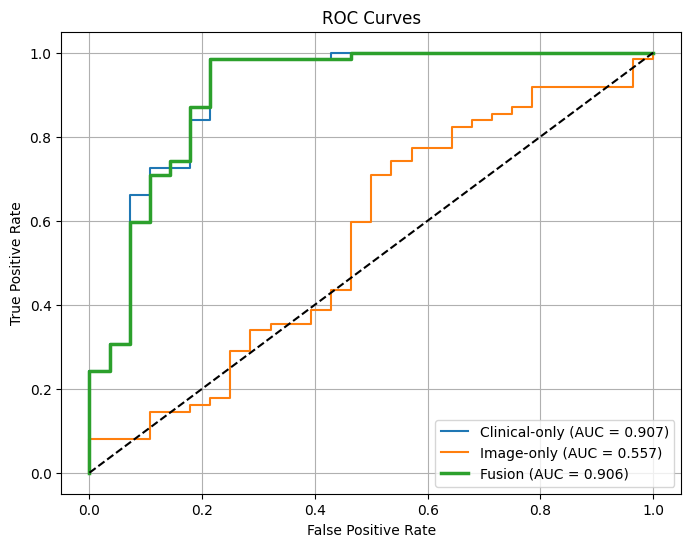

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

# Clinical-only
fpr_c, tpr_c, _ = roc_curve(y_true, p_clin)
auc_c = auc(fpr_c, tpr_c)
plt.plot(fpr_c, tpr_c, label=f"Clinical-only (AUC = {auc_c:.3f})")

# Image-only
fpr_i, tpr_i, _ = roc_curve(y_true, p_img)
auc_i = auc(fpr_i, tpr_i)
plt.plot(fpr_i, tpr_i, label=f"Image-only (AUC = {auc_i:.3f})")

# Fusion
fpr_f, tpr_f, _ = roc_curve(y_true, p_fused)
auc_f = auc(fpr_f, tpr_f)
plt.plot(fpr_f, tpr_f, label=f"Fusion (AUC = {auc_f:.3f})", linewidth=2.5)

# Formatting
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.show()


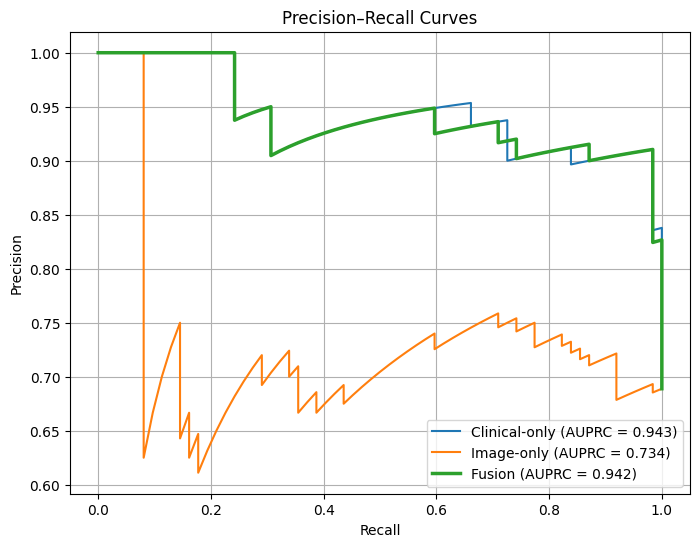

In [39]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8,6))

# Clinical-only
prec_c, rec_c, _ = precision_recall_curve(y_true, p_clin)
ap_c = average_precision_score(y_true, p_clin)
plt.plot(rec_c, prec_c, label=f"Clinical-only (AUPRC = {ap_c:.3f})")

# Image-only
prec_i, rec_i, _ = precision_recall_curve(y_true, p_img)
ap_i = average_precision_score(y_true, p_img)
plt.plot(rec_i, prec_i, label=f"Image-only (AUPRC = {ap_i:.3f})")

# Fusion
prec_f, rec_f, _ = precision_recall_curve(y_true, p_fused)
ap_f = average_precision_score(y_true, p_fused)
plt.plot(rec_f, prec_f, label=f"Fusion (AUPRC = {ap_f:.3f})", linewidth=2.5)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.grid(True)
plt.show()


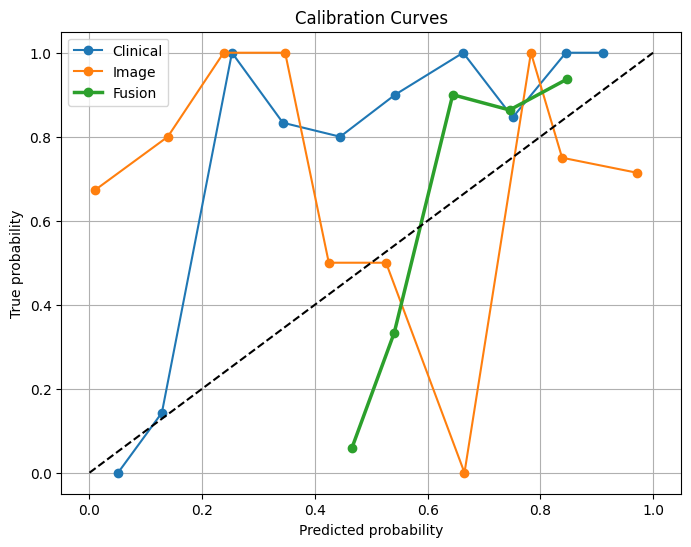

In [40]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8,6))

# Clinical
prob_true_c, prob_pred_c = calibration_curve(y_true, p_clin, n_bins=10)
plt.plot(prob_pred_c, prob_true_c, marker='o', label="Clinical")

# Image
prob_true_i, prob_pred_i = calibration_curve(y_true, p_img, n_bins=10)
plt.plot(prob_pred_i, prob_true_i, marker='o', label="Image")

# Fusion
prob_true_f, prob_pred_f = calibration_curve(y_true, p_fused, n_bins=10)
plt.plot(prob_pred_f, prob_true_f, marker='o', label="Fusion", linewidth=2.5)

# Perfect calibration line
plt.plot([0,1], [0,1], 'k--')

plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.title("Calibration Curves")
plt.legend()
plt.grid(True)
plt.show()
